1、Multiple ensembles shown to work. Analysis of why one ensemble performs better or worse than others. 
2、Analysis of interaction between hyperparameters and ensemble composition. 
3、Analysis of interaction between training/validation/testing and ensembles and hyperparameters. 
4、ROC created and all models/ensembles plotted on the same graph. ROC index calculated.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

OSError: dlopen(/usr/local/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /usr/local/lib/python3.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

In [2]:
# load datasets
def load_data(file):
    df_data = pd.read_csv(file)
    df_data.replace(['?'],[0], inplace =True)
    df_data.fillna(0, inplace =True)
    return df_data

df_data1 = load_data('ozone_onehr.csv')
df_data2 = load_data('ozone_eighthr.csv')

In [3]:
# training testing split, positive data is little, so just split dataset into two part.
def data_split(df_data, alpha):
    X_train, X_test, y_train, y_test = train_test_split(\
                            df_data.iloc[:, 1:-1].values, 
                            df_data.iloc[:, -1].values, 
                            test_size=alpha, 
                            random_state=42)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = data_split(df_data1, 0.4)

In [5]:
# define model
clf1 = LGBMClassifier(boosting_type='gbdt', 
                      objective='binary',
                      subsample=0.8, 
                      colsample_bytree=0.8, 
                      subsample_freq=1,
                      learning_rate=0.06, 
                      min_child_weight=1, 
                      random_state=20, 
                      n_jobs=4
                     )

clf2 = RandomForestClassifier(n_estimators=100,
                              criterion='gini',
                              max_depth=None, 
                              max_features='auto', 
                              min_samples_leaf=1, 
                              min_samples_split=2,
                              min_weight_fraction_leaf=0.0, 
                              n_jobs=4)

# 1) Multiple ensembles shown to work. Analysis of why one ensemble performs better or worse than others

In [20]:
# train model
clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

# predict
y_pre1 = clf1.predict_proba(X_test)[:, 1]
y_pre2 = clf2.predict_proba(X_test)[:, 1]

# calculate ROC index 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pre1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pre2)

ROC_index_XGB = [(i,j) for i,j in zip(fpr1, tpr1)]
print("First 5 ROC_index of XGB is:", ROC_index_XGB[:5]) # print first 5 ROC index 

ROC_index_RF = [(i,j) for i,j in zip(fpr2, tpr2)]
print("First 5 ROC_index of RF is:", ROC_index_RF[:5]) # print first 5 ROC index 

First 5 ROC_index of XGB is: [(0.0, 0.0), (0.0, 0.04), (0.00202020202020202, 0.04), (0.00202020202020202, 0.08), (0.005050505050505051, 0.08)]
First 5 ROC_index of RF is: [(0.0, 0.0), (0.0, 0.04), (0.00202020202020202, 0.04), (0.00202020202020202, 0.08), (0.005050505050505051, 0.08)]


AUC of XGB is: 0.9171717171717171
AUC of RF is: 0.8815151515151515


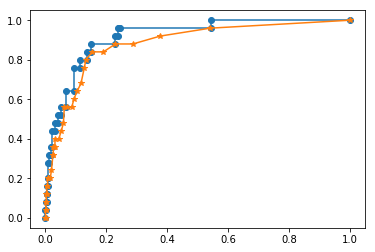

In [7]:
# calculate AUC
auc_score1 = metrics.roc_auc_score(y_test,y_pre1)
print('AUC of XGB is:', auc_score1)
auc_score2 = metrics.roc_auc_score(y_test,y_pre2)
print('AUC of RF is:',auc_score2)

# plot ROC of the models
plt.plot(fpr1, tpr1, marker = 'o', label="xgb")

plt.plot(fpr2, tpr2, marker = '*', label="RF")

plt.show()

XGBoost is one of boosting method, RF is one of bagging method, random forests and boosted trees are really the same models; the difference arises from how we train them. XGBoost simply take the gradient, and another important thing is XGBoost has regularization term. So XGBoost perform better than RF.

# 2) Analysis of interaction between hyperparameters and ensemble composition

In [1]:
lgb1 = LGBMClassifier(boosting_type='gbdt', 
                      max_depth=15, 
                      objective='binary'
                     )

lgb2 = LGBMClassifier(boosting_type='gbdt', 
                      max_depth=10, 
                      objective='binary'
                     )


lgb3 = LGBMClassifier(boosting_type='gbdt', 
                      max_depth=5, 
                      objective='binary'
                     )


NameError: name 'LGBMClassifier' is not defined

In [21]:
# train model
lgb1.fit(X_train, y_train)
lgb2.fit(X_train, y_train)
lgb3.fit(X_train, y_train)


# predict
y_pre1 = lgb1.predict_proba(X_test)[:, 1]
y_pre2 = lgb2.predict_proba(X_test)[:, 1]
y_pre3 = lgb3.predict_proba(X_test)[:, 1]

# calculate ROC index 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, y_pre1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, y_pre2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test, y_pre3)

ROC_index_LGB1 = [(i,j) for i,j in zip(fpr1, tpr1)]
print("First 5 ROC_index of XGB1 is:", ROC_index_XGB1[:5]) # print first 5 ROC index

ROC_index_LGB2 = [(i,j) for i,j in zip(fpr2, tpr2)]
print("First 5 ROC_index of XGB2 is:", ROC_index_XGB2[:5]) # print first 5 ROC index

ROC_index_LGB3 = [(i,j) for i,j in zip(fpr3, tpr3)]
print("First 5 ROC_index of XGB3 is:\n", ROC_index_XGB3[:5]) # print first 5 ROC index

First 5 ROC_index of XGB1 is: [(0.0, 0.0), (0.0, 0.04), (0.00202020202020202, 0.04), (0.00202020202020202, 0.08), (0.005050505050505051, 0.08)]
First 5 ROC_index of XGB2 is: [(0.0, 0.0), (0.0, 0.04), (0.0, 0.08), (0.0030303030303030303, 0.08), (0.0030303030303030303, 0.12)]
First 5 ROC_index of XGB3 is:
 [(0.0, 0.0), (0.0, 0.04), (0.007070707070707071, 0.04), (0.007070707070707071, 0.08), (0.00808080808080808, 0.08)]


AUC of XGB1 is: 0.9171717171717171
AUC of XGB2 is: 0.9052929292929293
AUC of XGB3 is: 0.8486464646464646


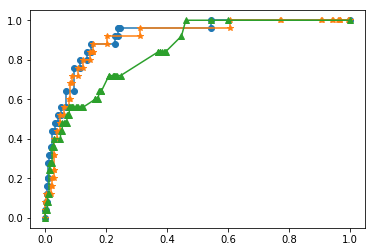

In [10]:
# calculate AUC
auc_score1 = metrics.roc_auc_score(y_test,y_pre1)
print('AUC of XGB1 is:', auc_score1)
auc_score2 = metrics.roc_auc_score(y_test,y_pre2)
print('AUC of XGB2 is:',auc_score2)
auc_score3 = metrics.roc_auc_score(y_test,y_pre3)
print('AUC of XGB3 is:',auc_score3)

# plot ROC of the models
plt.plot(fpr1, tpr1, marker = 'o')
plt.plot(fpr2, tpr2, marker = '*')
plt.plot(fpr3, tpr3, marker = '^')

plt.show()

'max_depth' in xgb1 is 3 and in xgb2 is 5, other hyperparameters are same, but xgb1's AUC is larger than xgb2's. 'learning_rate' in xgb1 is 0.1 and in xgb3 is 0.01, other hyperparameters are same, but xgb1's AUC is larger than xgb2's.

# 3) Analysis of interaction between training/validation/testing and ensembles and hyperparameters.

In [31]:
X_train1, X_test1, y_train1, y_test1 = data_split(df_data1, 0.2)
clf1 = LGBMClassifier(boosting_type='gbdt', objective='binary').fit(X_train1, y_train1)

X_train2, X_test2, y_train2, y_test2 = data_split(df_data1, 0.3)
clf2 = LGBMClassifier(boosting_type='gbdt', objective='binary').fit(X_train2, y_train2)

X_train3, X_test3, y_train3, y_test3 = data_split(df_data1, 0.7)
clf3 = LGBMClassifier(boosting_type='gbdt', objective='binary').fit(X_train3, y_train3)

# predict
y_pre1 = clf1.predict_proba(X_test1)[:, 1]
y_pre2 = clf2.predict_proba(X_test2)[:, 1]
y_pre3 = clf3.predict_proba(X_test3)[:, 1]

# calculate ROC index 
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test1, y_pre1)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test2, y_pre2)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test3, y_pre3)

ROC_index_LGB1 = [(i,j) for i,j in zip(fpr1, tpr1)]
print("First 5 ROC_index of XGB1 is:", ROC_index_XGB1[:5]) # print first 5 ROC index

ROC_index_LGB2 = [(i,j) for i,j in zip(fpr2, tpr2)]
print("First 5 ROC_index of XGB2 is:", ROC_index_XGB2[:5]) # print first 5 ROC index

ROC_index_LGB3 = [(i,j) for i,j in zip(fpr3, tpr3)]
print("First 5 ROC_index of XGB3 is:", ROC_index_XGB3[:5]) # print first 5 ROC index

First 5 ROC_index of XGB1 is: [(0.0, 0.0), (0.002004008016032064, 0.0), (0.006012024048096192, 0.0), (0.006012024048096192, 0.1111111111111111), (0.014028056112224449, 0.1111111111111111)]
First 5 ROC_index of XGB2 is: [(0.0, 0.0), (0.0, 0.05), (0.004048582995951417, 0.05), (0.004048582995951417, 0.15), (0.005398110661268556, 0.15)]
First 5 ROC_index of XGB3 is: [(0.0, 0.0), (0.000580046403712297, 0.0), (0.0034802784222737818, 0.0), (0.0034802784222737818, 0.038461538461538464), (0.0063805104408352666, 0.038461538461538464)]


AUC of XGB1 is: 0.8908928969049209
AUC of XGB2 is: 0.9114709851551956
AUC of XGB3 is: 0.8754629216491165


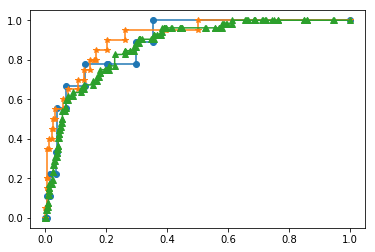

In [32]:
# calculate AUC
auc_score1 = metrics.roc_auc_score(y_test1, y_pre1)
print('AUC of LGB1 is:', auc_score1)
auc_score2 = metrics.roc_auc_score(y_test2, y_pre2)
print('AUC of LGB2 is:',auc_score2)
auc_score3 = metrics.roc_auc_score(y_test3, y_pre3)
print('AUC of LGB3 is:',auc_score3)

# plot ROC of the models
plt.plot(fpr1, tpr1, marker = 'o')
plt.plot(fpr2, tpr2, marker = '*')
plt.plot(fpr3, tpr3, marker = '^')

plt.show()

'test_size' of three dataset is 0.2, 0.3, 0.4, when I increase 'test_size', the AUC of the model is alse increase; but when 'test_size' increase too large, AUC begin decrease. When 'test_size' is small, more data will be use for training, when is large, less data will be use for training, it has better choosing appropriate 'test_size'.